# A System for Real Time Facial Emotion Recognition


### Step-1: Importing libraries


In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow import keras
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.utils import plot_model


**Imported Libraries uses**<br>
**1. Pandas:** Used for data manipulation and analysis<br>
**2. NumPy:** Used for scientific calculations. Perform mathematical and logical operations on Arrays.<br>
**3. Os:** Used to handle files using system commands<br>
**4. Tensorflow:** An open source machine learning framework, or implementing machine learning and deep learning applications. It has pre-trained models that easily help with image classification. The images are classified using CNN<br>
**5. Matplotlib:** Used for data visualization and graphical plotting<br>
**6. cv2:** OpenCV is a video and image processing library and it is used for image and video analysis, like facial detection<br>
**7. load_img:** Used to load image in keras<br>
**8. Keras:** Keras is a deep learning library <br>
**9. Layers:** Keras Layers are the functional building blocks of Keras Models<br>


### Step-2: Data Preprocessing

#### Load the test data and the train data


In [2]:
train_directory = "./Dataset/FER-2013/train/"
test_directory = "./Dataset/FER-2013/test/"


#### Data Exploration

In [3]:
def count_expression(path, set_):
    # using a dictionary to store expression as key and total number of that expression as value
    expression_count_dic = {}

    for expression in os.listdir(path):
        dir_ = path + expression
        # print(dir_)
        expression_count_dic[expression] = len(os.listdir(dir_))

    # print(expression_count_dic)
    # Pandas DataFrame is a 2 dimensional data structure, or a table with rows and columns
    df = pd.DataFrame(expression_count_dic, index=[set_])
    return df


train_count = count_expression(train_directory, 'train')
test_count = count_expression(test_directory, 'test')

print(train_count)
print(test_count)


       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


##### Plot of number of images in training set


<AxesSubplot: >

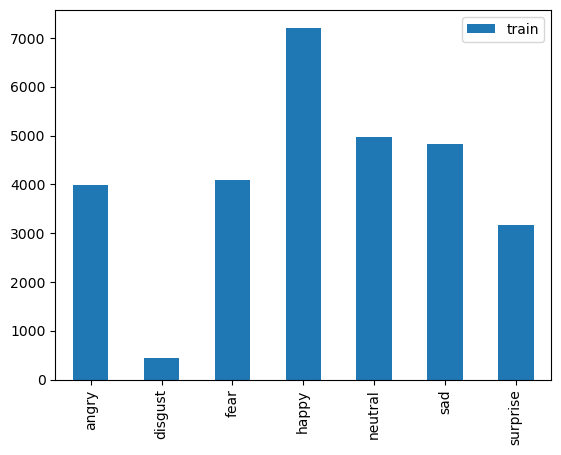

In [4]:
train_count.transpose().plot(kind='bar')


##### Plot of number of images in test set


<AxesSubplot: >

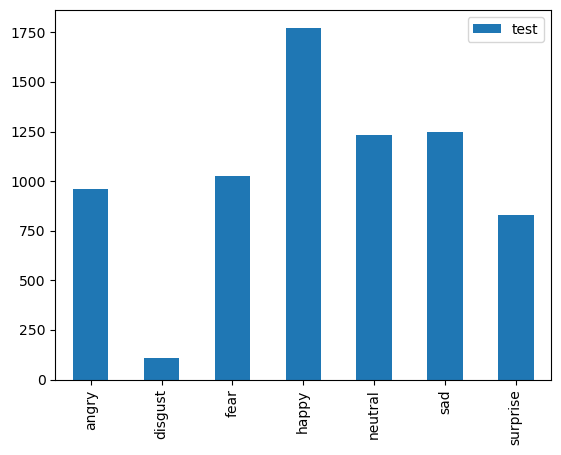

In [5]:
test_count.transpose().plot(kind='bar')


#### Make a data directory for training and testing


In [6]:
train_directory = "./Dataset/FER-2013/train/"
# list of classes(folders)=>Categories or labels.
train_data_labels_or_folders= ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]


In [7]:
test_directory = "./Dataset/FER-2013/test/"
# list of classes(folders)=>Categories or labels.
test_data_labels_or_folders= ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

#### Image preprocessing

##### Plotting an image for every labels in the training set


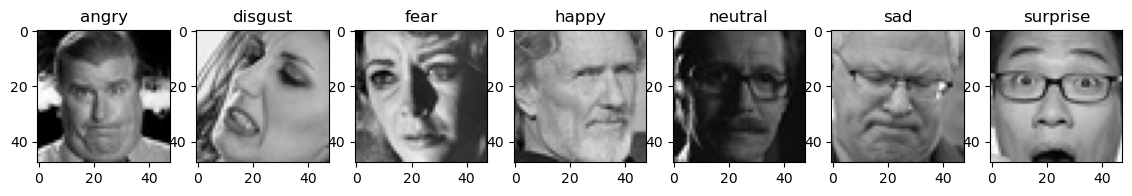

In [8]:
plt.figure(figsize=(14, 22))
i = 1

for expression in train_data_labels_or_folders:
    path = train_directory + expression
    # load 100th image of every expression from the training set
    img = load_img((path + '/' + os.listdir(path)[100]))

    plt.subplot(1, 7, i)  # 1 row, 7 column, i index
    plt.imshow(img)
    plt.title(expression)
    i += 1
plt.show()


##### Read a particular image from the train set and test set to check the size


(48, 48, 3)

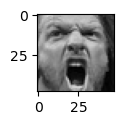

In [9]:
# for train set
plt.figure(figsize=(1, 1))
# cv2.imread() method loads an image from the specified file.
an_img_train = cv2.imread("./Dataset/FER-2013/train/angry/Training_21282633.jpg")
plt.imshow(an_img_train)
an_img_train.shape  # check size


(48, 48, 3)

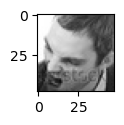

In [10]:
# for test set
plt.figure(figsize=(1, 1))
an_img_test = cv2.imread("./Dataset/FER-2013/test/angry/PrivateTest_10590091.jpg")
plt.imshow(an_img_test)
an_img_test.shape  # check size

Here plotted a BGR image. Because OpenCV reads in images in BGR(blue, green, red) format instead of RGB(red blue green).

There is a difference in pixel ordering in OpenCV and Matplotlib. OpenCV follows BGR order, while matplotlib likely follows RGB order. Therefore, when we display an image loaded in OpenCV using matplotlib functions, we may want to convert it into RGB mode.


#### Change the size and pixel ordering of the train and test images


We will use transfer learning in this project. So for transfer learning if we want to use any deep learning classifier then the image dimensions must be same. <br>
ImageNet is one of the most widely used large scale dataset for benchmarking Image Classification algorithms which contains images of fixed size of 224x224 and have RGB channels but as fer2013 has images of size 48x48 so we’ll resize the images.


(224, 224, 3)

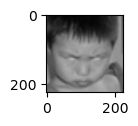

In [11]:
# for train set
img_new_size = 224  # ImageNet dataset size is 224x224.

for expression in train_data_labels_or_folders:
    path = os.path.join(train_directory, expression)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        # img_array.shape

        # OpenCV provides cv2.resize() function to resize image
        img_array = cv2.resize(img_array, (img_new_size, img_new_size))

        plt.figure(figsize=(1, 1))
        # cv2.cvtColor() method is used to convert an image from one color space to another. here BGR to RGB
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        break  # we use break here to stop plotting all images. Here only 1st image of the dataset will be plotted
    break
img_array.shape


(224, 224, 3)

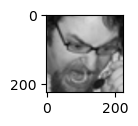

In [12]:
# for test set
img_new_size = 224  # ImageNet dataset size is 224x224.

for expression in test_data_labels_or_folders:
    path = os.path.join(test_directory, expression)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.resize(img_array, (img_new_size, img_new_size))
        plt.figure(figsize=(1, 1))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        break  
    break
img_array.shape

##### Read all the images of training and testing directory and convert them to array.


In [13]:
# for training
training_Data = []  # to store all images in the training data array


def create_training_Data():
    for expression in train_data_labels_or_folders:
        path = os.path.join(train_directory, expression)
        class_num = train_data_labels_or_folders.index(expression)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (img_new_size, img_new_size))
                training_Data.append([img_array, class_num])  # add to array
            except Exception as e:
                pass
            
create_training_Data()  # call the function

In [14]:
# for testing
testing_Data = []  # to store all images in the training data array

def create_testing_Data():
    for expression in test_data_labels_or_folders:
        path = os.path.join(test_directory, expression)
        class_num = test_data_labels_or_folders.index(expression)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (img_new_size, img_new_size))
                testing_Data.append([img_array, class_num])  # add to array
            except Exception as e:
                pass
            
create_testing_Data()  # call the function

##### Check the shape of the train and test array


In [16]:
# Train set
# create NumPy array.
np_training_array = np.array(training_Data, dtype=object)
np_training_array.shape


(28709, 2)

Here array shape (28709,2) means it is a 2-D array. Here it have 28709 rows(images) and 2 columns(1 is data feature and 1 is label or expression)


In [17]:
# test set
np_testing_array = np.array(testing_Data, dtype=object)
np_testing_array.shape

(7178, 2)

##### Shuffle the sequence<br>

To make our deep learning architecture dynamic and robust, we need to shuffle the sequence


In [18]:
random.shuffle(training_Data)


#### Separate the features and labels


label 0 = angry,
label 1 = disgust,
label 2 = fear,
label 3 = happy,
label 4 = neutral,
label 5 = sad,
label 6 = surprize,


In [19]:
X_train_Images = []  # to store data features or images
Y_train_labels = []  # to store labels or categories

for features, label in training_Data:
    X_train_Images.append(features)  # images
    Y_train_labels.append(label)  # categories

# reshape the features list to 4 dimension.
X_train_Images = np.array(X_train_Images).reshape(-1, img_new_size, img_new_size, 3)
Y_train_labels = np.array(Y_train_labels)
X_train_Images.shape


(28709, 224, 224, 3)

We’ll use MobileNet architecture which takes 4 dimensions, so here we reshaped the features list. MobileNet is a CNN architecture model for Image Classification. <br>
In np.array(X_train_Images).reshape(-1, img_new_size, img_new_size, 3) function -1 refers to an unknown dimension that the reshape() function calculates.
<br>
here output (28709, 224, 224, 3) means 28709 is number of images; 224, 224 is the image size. and 3 is the number of channels(RGB)


In [20]:
X_test_Images = []  # to store data features or images
Y_test_labels = []  # to store labels or categories

for features, label in testing_Data:
    X_test_Images.append(features)  # images
    Y_test_labels.append(label)  # categories

# reshape the features list to 4 dimension.
X_test_Images = np.array(X_test_Images).reshape(-1, img_new_size, img_new_size, 3)
Y_test_labels = np.array(Y_test_labels)
X_test_Images.shape


(7178, 224, 224, 3)

#### Normalize Data


Scaling data to the range of 0-1 is traditionally referred to as normalization. Normalizing the data generally speeds up learning and leads to faster convergence.


In [21]:
# X_train_Images = X_train_Images/255
# X_train_Images = ImageDataGenerator(rescale=1.0/255.0) # The ImageDataGenerator class can be used to rescale pixel values from the range of 0-255 to the range 0-1 preferred for neural network models.


### Step-3: Create our deep learning model using transfer learning


The reuse of a pre-trained model on a new problem is known as transfer learning in machine learning.

MobileNet-v2 is a convolutional neural network that is 53 layers deep. It's been pre-trained on ImageNet, a dataset containing over 14 million images and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224

##### MobileNetV2

In [22]:
# MobileNetV2 is a pre-trained model for image classification.
model = tf.keras.applications.MobileNetV2()


In [23]:
model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

##### MobileNetV2 Transfer Learning


Remove the top layers of the model and add new layers that are suitable for the FER-2013 dataset

In [24]:
# check 1st layer. layers[0] means input 1st layer
base_input = model.layers[0].input
print("Base input: ", base_input)

# As we want seven classes, so let’s cut down the second last layers which have output(None, 1280)
base_output = model.layers[-2].output
print("Base output: ", base_output)

Base input:  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Base output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")


Adding three new layer


In [25]:
# creating new layer after the global pooling layer
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)  # activation function

final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)

# 7 because we will use 7 classes. This is the classification layer.
final_output = layers.Dense(7, activation='softmax')(final_output)
print("final_output: ", final_output)

final_output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


The dense layer is a neural network layer that is connected deeply. Each neuron in the dense layer receives input from all neurons of its previous layer.<br>
The activation function is a mathematical “gate” in between the input feeding the current neuron and its output going to the next layer.<br>
relu is a non-linear activation function that performs on multi-layer neural networks.


#### Create our new model


In [26]:
# my input is base input and my output is the final output
new_model = keras.Model(inputs=base_input, outputs=final_output)


In [27]:
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

This model is almost same as the previous model cz the base input and final output was same. Its just added 3dense layers(fully connected layer) after the global layer. And the previous models last connected layers activation function was ReLu but here it is SoftMax(classification layer).


In [28]:
# plot_model(new_model, to_file="FERModel.png", show_shapes=True, show_layer_names=True)


#### Compile


Compile defines the loss function, the optimizer, and the metrics. We need a compiled model to train (because training uses the loss function and the optimizer).


In [29]:
new_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])


Here,<br>
**sparse_categorical_crossentropy:** Used as a loss function for multi-class classification model where the output label is assigned integer value (0, 1, 2, 3…)<br>
**adam:** Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Adam optimizer is the extended version of stochastic gradient descent.The results of the Adam optimizer are generally better than every other optimization algorithms, have faster computation time, and require fewer parameters for tuning. <br>
**accuracy:** A metric is a function that is used to judge the performance of your model. Accuracy compute the frequency with which y_pred matches y_true.


### Step 4: Train the model


Epoch is the total number of iterations of the training data in one cycle.<br>
In general too many epochs may cause a model to over-fit the training data. It means that using too big epoch the model does not learn the data, it memorizes the data.
A size of 25 has been found to be one of the most optimal for most use cases. So we will use 25 epoch for our 28709 training data.

In [30]:
print("Train Images shape and datatype:" ,X_train_Images.shape, X_train_Images.dtype)
print("Train labels shape and datatype:" ,Y_train_labels.shape, Y_train_labels.dtype)

Train Images shape and datatype: (28709, 224, 224, 3) uint8
Train labels shape and datatype: (28709,) int32


##### After being trained we will save the model and comment it out. so that we can save our time by just loading this saved model.

In [31]:
# new_model_30 = new_model.fit(X_train_Images, Y_train_labels, epochs= 30, validation_data=(X_test_Images, Y_test_labels))

Epoch 1/30
898/898 [==============================] - 6841s 8s/step - loss: 1.2383 - accuracy: 0.5364 - val_loss: 6.0082 - val_accuracy: 0.2002
Epoch 2/30
898/898 [==============================] - 12180s 14s/step - loss: 1.0722 - accuracy: 0.5991 - val_loss: 4.5287 - val_accuracy: 0.1945
Epoch 3/30
898/898 [==============================] - 5689s 6s/step - loss: 1.0027 - accuracy: 0.6276 - val_loss: 1.6984 - val_accuracy: 0.4635
Epoch 4/30
898/898 [==============================] - 5658s 6s/step - loss: 0.9476 - accuracy: 0.6478 - val_loss: 1.7894 - val_accuracy: 0.4792
Epoch 5/30
898/898 [==============================] - 5650s 6s/step - loss: 0.8921 - accuracy: 0.6662 - val_loss: 2.1051 - val_accuracy: 0.4734
Epoch 6/30
898/898 [==============================] - 5747s 6s/step - loss: 0.8390 - accuracy: 0.6890 - val_loss: 1.5009 - val_accuracy: 0.5419
Epoch 7/30
898/898 [==============================] - 5966s 7s/step - loss: 0.7869 - accuracy: 0.7095 - val_loss: 2.8348 - val_accurac

##### Save the trained model history to use it further

after saving comment it out so that you can use it later just by loading

In [69]:
# np.save('new_model_30_history.npy',new_model_30.history)

##### Load the saved history

In [70]:
history_30=np.load('new_model_30_history.npy',allow_pickle='TRUE').item()

Then history_30 is a dictionary and you can retrieve all desirable values using the keys(accuracy, loss, val_accuracy, val_loss)

##### Save the trained model to use it further

Keras supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information.

after saving comment it out so that you can use it later just by loading

In [71]:
# new_model.save('Final_model_30.h5') ## creates a HDF5 file

##### Load the saved model

In [72]:
saved_model_30 = tf.keras.models.load_model(
    'Final_model_30.h5')  # loading my trained model

### Step 5: Evaluate the model

##### Accessing Training and validation accuracy and loss

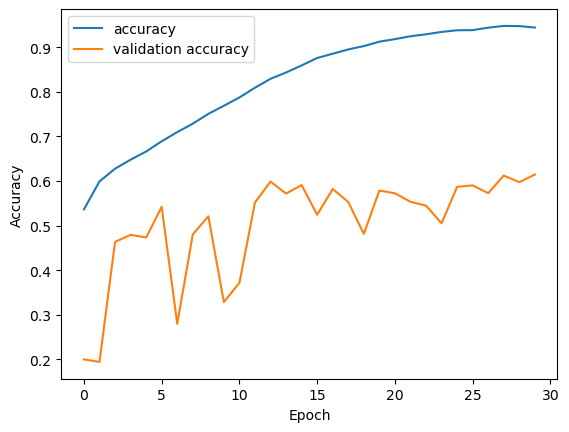

In [73]:
# Accessing training accuracy and validation accuracy for each epoch
accuracy = history_30["accuracy"]
validation_accuracy =history_30['val_accuracy']

# Plotting training accuracy and validation accuracy
plt.plot(accuracy, label="accuracy")
plt.plot(validation_accuracy, label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

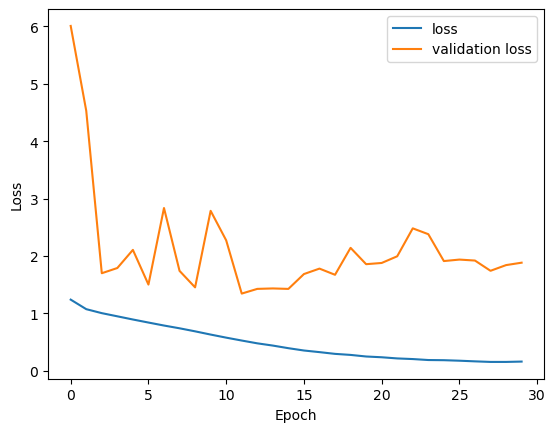

In [77]:
# Accessing training loss and validation loss for each epoch
loss = history_30["loss"]
validation_loss = history_30['val_loss']

#Plotting training loss and validation loss
plt.plot(loss, label="loss")
plt.plot(validation_loss, label="validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#### Test the model using random pictures

To detect the face emotion from random image or videp we need to detect the face from the image. We will use Haar Cascade to identify the face.


Haar Cascade is an Object Detection Algorithm used to identify faces in an image or a real time video. It works with gray scale images.


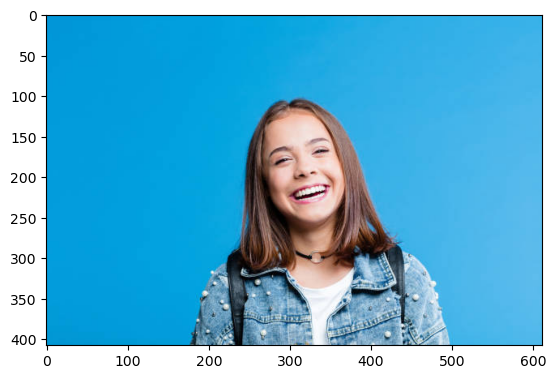

In [92]:
# Load the cascade
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


# Read the input image
an_test_image = cv2.imread("./Happy.jpg")
an_test_image.shape

# converted in rgb because matplotlib plot an bgr image
plt.imshow(cv2.cvtColor(an_test_image, cv2.COLOR_BGR2RGB))

### openCV code to detect face


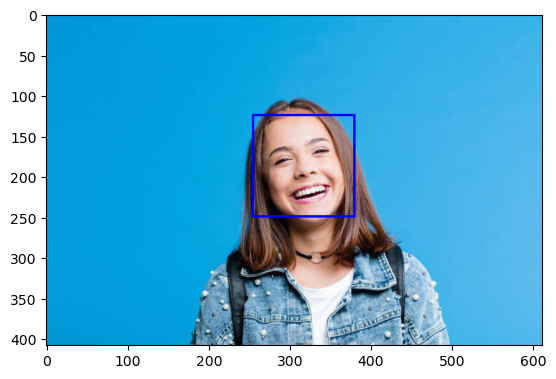

In [93]:
# Detect faces
faces = faceCascade.detectMultiScale(gray_img, 1.1, 4)

# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(an_test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    roi_gray = gray_img[y:y+h, x:x+w]
    roi_color = an_test_image[y:y+h, x:x+w]

    faces = faceCascade.detectMultiScale(roi_gray)

    if len(faces) == 0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in faces:
            # region/boundary for face
            face_roi = roi_color[ey:ey+eh, ex:ex+ew]
            
# Display the output
plt.imshow(cv2.cvtColor(an_test_image, cv2.COLOR_BGR2RGB))

##### Crop the face area


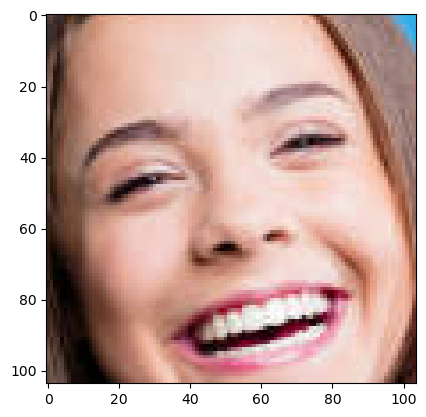

In [94]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))


In [95]:
an_test_image = cv2.resize(face_roi, (224, 224))  # resize
an_test_image = np.expand_dims(an_test_image, axis=0)  # add a fourth dimension

Predictions = saved_model_30.predict(an_test_image)


1/1 [==============================] - 1s 1s/step


In [96]:
Predictions[0]
np.argmax(Predictions)

3

# Real Time Video Demo Using OpenCV

Opencv is a computer vision library. This library has multiple functionalities so that we can process our images and videos using the webcam and programming. <br>
OpenCV captures the video frames and preprocesses them in a similar way as we did for the FER-2013 dataset. Then, we pass the preprocessed frames through our model to classify the emotions

In [97]:
from deepface import DeepFace
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN  # font style

# set the rectangle background to white
rectangle_bgr = (255, 255, 255)
# make a black image
img = np.zeros((500, 500))
# set some text
text = "Some text in a box!"
# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(
    text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
# make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x +
              text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font,
            fontScale=font_scale, color=(0, 0, 0), thickness=1)


cap = cv2.VideoCapture(1)
# Check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:  # infinite while loop
    ret, frame = cap.read()
    faceCascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    # for all faces in the corresponding frame
    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        faces = faceCascade.detectMultiScale(roi_gray)
        if len(faces) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in faces:
                # cropping the face
                face_roi = roi_color[ey: ey+eh, ex:ex + ew]

    final_image = cv2.resize(face_roi, (224, 224))
    final_image = np.expand_dims(final_image, axis=0)  # need fourth dimension

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions = saved_model_30.predict(final_image)

    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN

    if (np.argmax(Predictions) == 0):
        status = "Angry"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions) == 1):
        status = "Disgust"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions) == 2):
        status = "Fear"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions) == 3):
        status = "Happy"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions) == 4):
        status = "Sad"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions) == 5):
        status = "Surprise"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    else:
        status = "Neutral"

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, status, (100, 150), font,
                    3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    cv2.imshow('Face Emotion Recognition', frame)
    # To quit, hit the key q "on" the video window(s) to stop the camera.
    if cv2.waitKey(3) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows() # destroyAllWindows() will destroy windows
cap.release() # cap.release() will close our camera.


1/1 [==============================] - 0s 110ms/step
Face not detected
1/1 [==============================] - 0s 82ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 80ms/step
Face not detected
1/1 [==============================] - 0s 80ms/step
Face not detected
1/1 [==============================] - 0s 86ms/step
Face not detected
1/1 [==============================] - 0s 76ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 86ms/step
Face not detected
1/1 [==============================] - 0s 84ms/step
Face not detected
1/1 [==============================] - 0s 85ms/step
Face not detected
1/1 [==============================] - 0s 88ms/step
Face not detected
1/1 [==============================] - 0s 89ms/step
Face not detected
1/1 [==============================] - 0s 83ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 110ms/step
Face not detected
1/1 [=============================